# Neural Style Transfer with Adversarially Robust Classifiers

This is an accompanying notebook for the blog post https://reiinakano.com/2019/06/21/robust-neural-style-transfer.html

This code is not meant to be run without a GPU.


This has been merged with 'neural transfer using pytorch' documentation


TRAINS - Example of Pytorch and matplotlib integration and reporting

"""
Neural Transfer Using PyTorch
=============================
**Author**: `Alexis Jacq <https://alexis-jacq.github.io>`_
**Edited by**: `Winston Herring <https://github.com/winston6>`_
Introduction
------------
This tutorial explains how to implement the `Neural-Style algorithm <https://arxiv.org/abs/1508.06576>`__
developed by Leon A. Gatys, Alexander S. Ecker and Matthias Bethge.
Neural-Style, or Neural-Transfer, allows you to take an image and
reproduce it with a new artistic style. The algorithm takes three images,
an input image, a content-image, and a style-image, and changes the input
to resemble the content of the content-image and the artistic style of the style-image.
.. figure:: /_static/img/neural-style/neuralstyle.png
   :alt: content1
"""

#####################################################################
 Underlying Principle
 --------------------

 The principle is simple: we define two distances, one for the content
 (:math:`D_C`) and one for the style (:math:`D_S`). :math:`D_C` measures how different the content
 is between two images while :math:`D_S` measures how different the style is
 between two images. Then, we take a third image, the input, and
 transform it to minimize both its content-distance with the
 content-image and its style-distance with the style-image. Now we can
 import the necessary packages and begin the neural transfer.

#Importing Packages and Selecting a Device
 -----------------------------------------
 Below is a  list of the packages needed to implement the neural transfer. (robustness_lib not included!)

 -  ``torch``, ``torch.nn``, ``numpy`` (indispensables packages for
    neural networks with PyTorch)
 -  ``torch.optim`` (efficient gradient descents)
 -  ``PIL``, ``PIL.Image``, ``matplotlib.pyplot`` (load and display
    images)
 -  ``torchvision.transforms`` (transform PIL images into tensors)
 -  ``torchvision.models`` (train or load pre-trained models)
 -  ``copy`` (to deep copy the models; system package)

## Download dependencies and sample images

In [ ]:
#!git clone https://github.com/red8top/robustness_lib.git /home/robustness_lib
#!wget https://s3-us-west-2.amazonaws.com/andrewilyas.com/RestrictedImageNet.pt -O /home/RestrictedImageNet.pt

In [ ]:
!pwd

In [ ]:
#!ls /home
#!ls /content/drive/My\ Drive/pics/RobustResNET
#!cp /content/drive/My\ Drive/pics/RobustResNET/* ./

In [ ]:
!wget https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg
!wget https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg
!wget https://storage.googleapis.com/tensorflow-lucid/static/img/notebook-styletransfer-bigben.jpg
!wget https://storage.googleapis.com/tensorflow-lucid/static/img/starry-night.png
!wget https://raw.githubusercontent.com/jcjohnson/neural-style/master/examples/inputs/the_scream.jpg
!wget https://raw.git
!wget https://raw.githubusercontent.com/jcjohnson/neural-style/master/examples/inputs/tubingen.jpghubusercontent.com/jcjohnson/neural-style/master/examples/inputs/escher_sphere.jpg
!wget https://raw.githubusercontent.com/jcjohnson/neural-style/master/examples/inputs/woman-with-hat-matisse.jpg
!wget https://images.academics.com/working-in-tuebingen.jpg

In [ ]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install trains

#YOU CAN RUN EVERYTHING FROM THIS ONE SCRIPT AND THEN THE FOLLOWING CODE CHUNK

In [2]:
!mkdir testrun

In [11]:
!pwd

/home/jesse/Documents/robustness_lib


In [1]:
from trains import Task


task = Task.init(project_name='stylegan', task_name='pytorch stylegan onescript', task_type=Task.TaskTypes.testing)



TRAINS Task: created new task id=b2509e6365ca4ece93b12210abe148ea
======> WARNING! UNCOMMITTED CHANGES IN REPOSITORY git@github.com:red8top/robustness_lib.git <======
TRAINS results page: http://localhost:8080/projects/491f17dfa2d643129f9efc16002e9f61/experiments/b2509e6365ca4ece93b12210abe148ea/output/log


/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.



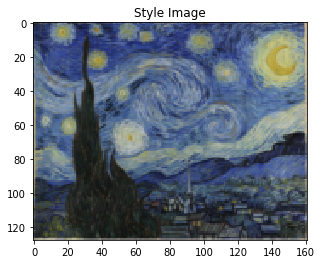

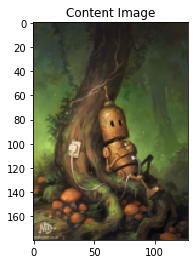

=> loading checkpoint '/home/jesse/Documents/robustness_lib/RestrictedImageNet.pt'


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location='cpu' to map your storages to the CPU.

2019-07-01 15:26:51,015 - trains.Task - WARNING - ### TASK STOPPED - USER ABORTED - STATUS CHANGED ###


In [2]:
%run -i runAllAtOncestylegan2.py starry-night.png robotsoul3.jpg

In [ ]:
out = style_transfer(
    ResNetStyleTransferModel(robust_resnet, dataset.mean, dataset.std), 
    style_img, content_img, style_weight=1e9, content_weight=0.5,
    start_from_content=True, n_iters=[0, 50, 100], opt='LBFGS')

## Imports

In [ ]:

import sys
sys.path.append('/home/robustness_lib')
import os
import io
import json
import time
import copy
import glob

from PIL import Image

import matplotlib.pyplot as plt

import torch as ch
import torch.nn.functional as functional
import torch.optim as optim
import torch.utils.model_zoo as model_zoo
import torch.nn as nn

import torchvision.transforms.functional as F
import torchvision.models as models
from torchvision import transforms

#from robustness import datasets, model_utils, constants, helpers


In [ ]:
from robustness import datasets, model_utils, constants, helpers

Next, we need to choose which device to run the network on and import the
content and style images. Running the neural transfer algorithm on large
images takes longer and will go much faster when running on a GPU. We can
use ``torch.cuda.is_available()`` to detect if there is a GPU available.
Next, we set the ``torch.device`` for use throughout the tutorial. Also the ``.to(device)``
method is used to move tensors or modules to a desired device.

In [ ]:
device = ch.device("cuda" if ch.cuda.is_available() else "cpu")

 Loading the Images
 ------------------

 Now we will import the style and content images. The original PIL images have values between 0 and 255, but when
 transformed into torch tensors, their values are converted to be between
 0 and 1. The images also need to be resized to have the same dimensions.
 An important detail to note is that neural networks from the
 torch library are trained with tensor values ranging from 0 to 1. If you
 try to feed the networks with 0 to 255 tensor images, then the activated
 feature maps will be unable sense the intended content and style.
 However, pre-trained networks from the Caffe library are trained with 0
 to 255 tensor images.


 .. Note::
     Here are links to download the images required to run the tutorial:
     `picasso.jpg <https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg>`__ and
     `dancing.jpg <https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg>`__.
     Download these two images and add them to a directory
     with name ``images`` in your current working directory.

In [ ]:


# desired size of the output image
imsize = 512 if ch.cuda.is_available() else 128  # use small size if no gpu


def image_loader(image_name):
  loader = transforms.Compose([
      transforms.Resize(imsize),  # scale imported image
      transforms.ToTensor()])  # transform it into a torch tensor

  image = Image.open(image_name)
  # fake batch dimension required to fit network's input dimensions
  image = loader(image).unsqueeze(0)[:, :3, :, :]
  return image.to(device, ch.float)


def imshow(tensor, title=None):
  unloader = transforms.ToPILImage()  # reconvert into PIL image

  image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
  image = image.squeeze(0)      # remove the fake batch dimension
  image = unloader(image)
  plt.imshow(image)
  if title is not None:
      plt.title(title)
  plt.pause(0.001) # pause a bit so that plots are updated

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#!ls /content/drive/My\ Drive/pics
!cp /content/drive/My\ Drive/pics/RobustResNET/* ./

In [ ]:
!ls
!pwd

## Prepare the trained models

In [ ]:
dataset = datasets.RestrictedImageNet('')

model_kwargs = {
    'arch': 'resnet50',
    'dataset': dataset,
    'resume_path': '/home/RestrictedImageNet.pt',
    'state_dict_path': 'model',
    'parallel': False
}

# Robust ResNet
model, ckpt = model_utils.make_and_restore_model(**model_kwargs)
robust_resnet = model.model

# Regular ResNet
reg_resnet = copy.deepcopy(robust_resnet)
new_params = reg_resnet.state_dict()
partial_params = model_zoo.load_url('https://download.pytorch.org/models/resnet50-19c8e357.pth')
del partial_params['fc.bias']
del partial_params['fc.weight']
new_params.update(partial_params)
reg_resnet.load_state_dict(new_params)

# VGG
vgg = models.vgg19(pretrained=True).features

## Style transfer code

In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, feature_maps,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.feature_maps = {key: val.detach() for key, val in feature_maps.items()}

    def forward(self, input, layer_name):
        return functional.mse_loss(input[layer_name], self.feature_maps[layer_name])

def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = ch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)
  
class StyleLoss(nn.Module):

    def __init__(self, feature_maps):
        super(StyleLoss, self).__init__()
        self.feature_maps = {key: gram_matrix(val).detach() for key, val in feature_maps.items()}

    def forward(self, input, layer_name):
        G = gram_matrix(input[layer_name])
        return functional.mse_loss(G, self.feature_maps[layer_name])



In [ ]:
class ResNetStyleTransferModel(nn.Module):
  """This class is used to wrap a ResNet model for style transfer"""
  def __init__(self, model, mean, std):
    super(ResNetStyleTransferModel, self).__init__()
    self.normalize = helpers.InputNormalize(mean, std)
    self.model = model  # Resnet50 model
   
  def forward(self, x):
    layers = {}
    
    x = self.normalize(x)
    
    x = self.model.conv1(x)
    x = self.model.bn1(x)
    x = self.model.relu(x)
    x = self.model.maxpool(x)
    
    x = self.model.layer1(x)
    layers['conv_1'] = x
    x = self.model.layer2(x)
    layers['conv_2'] = x
    x = self.model.layer3(x)
    layers['conv_3'] = x
    x = self.model.layer4(x, fake_relu=True)
    layers['conv_4'] = x
    
    return layers

In [ ]:
class VGGStyleTransferModel(nn.Module):
  """This class is used to wrap a VGG model for style transfer"""
  def __init__(self, model, mean, std):
    super(VGGStyleTransferModel, self).__init__()
    self.normalize = helpers.InputNormalize(mean, std)
    self.model = model  # VGG model

  def forward(self, x):
    layers = {}
    
    x = self.normalize(x)
    
    i=0
    for layer in self.model.children():
      if isinstance(layer, nn.Conv2d):
          i += 1
          name = 'conv_{}'.format(i)
      elif isinstance(layer, nn.ReLU):
          name = 'relu_{}'.format(i)
          # The in-place version doesn't play very nicely with the ContentLoss
          # and StyleLoss we insert below. So we replace with out-of-place
          # ones here.
          layer = nn.ReLU(inplace=False)
      elif isinstance(layer, nn.MaxPool2d):
          name = 'pool_{}'.format(i)
          layer = nn.AvgPool2d(kernel_size=2, stride=2)
      elif isinstance(layer, nn.BatchNorm2d):
          name = 'bn_{}'.format(i)
      else:
          raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
      x = layer(x)
      
      if isinstance(layer, nn.Conv2d):
        layers[name] = x
      if i == 13:  # This is the last layer we usually use for style transfer
        break
    return layers

In [ ]:
def get_input_optimizer(input_img, opt='Adam'):
    # this line to show that input is a parameter that requires a gradient
    if opt == 'Adam':
      optimizer = optim.Adam([input_img.requires_grad_()], lr=0.01)
    elif opt == 'LBFGS':
      optimizer = optim.LBFGS([input_img.requires_grad_()])
    else:
      raise RuntimeError('Unrecognized optimizer: {}'.format(opt))
    return optimizer

Below,  if run[0] in n_iters:
changed to 
if true:

In [ ]:
def style_transfer(st_model, content_img, style_img, start_from_content=True,
                   n_iters=[0, 2000], style_weight=1e9, content_weight=1,
                   content_layers=['conv_3'], style_layers=['conv_1', 'conv_2', 'conv_3', 'conv_4'],
                   opt='Adam',
                   verbose=True,
                   ):
  st_model.eval().cuda()
  
  if isinstance(content_img, str):
    content_img = image_loader(content_img)
  
  if isinstance(style_img, str):
    style_img = image_loader(style_img)
  
  content_feature_maps = st_model(content_img)
  content_feature_maps = {key: val.detach() for key, val in content_feature_maps.items()}
  
  style_feature_maps = st_model(style_img)
  style_feature_maps = {key: val.detach() for key, val in style_feature_maps.items()}
  
  content_loss_func = ContentLoss(content_feature_maps)
  style_loss_func = StyleLoss(style_feature_maps)
  
  if start_from_content:
    input_img = content_img.clone()
  else:
    input_img = ch.randn(content_img.data.size(), device=device)
    
  optimizer = get_input_optimizer(input_img, opt=opt)
  
  images = []
  run = [0]
  start_time = time.time()
  while run[0] <= n_iters[-1]:
    def closure():
      # correct the values of updated input image
      input_img.data.clamp_(0, 1)

      optimizer.zero_grad()
      input_feature_maps = st_model(input_img)
      
      style_score = 0
      content_score = 0
      edition = 1

      for sl in style_layers:
          _l = style_loss_func(input_feature_maps, sl) * style_weight
          style_score += _l
          #print(_l)
      for cl in content_layers:
          content_score += content_loss_func(input_feature_maps, cl) * content_weight
          #print(content_score)

      #style_score *= style_weight
      #content_score *= content_weight

      loss = style_score + content_score
      loss.backward()
      
      if True:
          print("run {}:".format(run))
          print('Style Loss : {:4f} Content Loss: {:4f} time elapsed: {} seconds'.format(
              style_score.item(), content_score.item(), time.time() - start_time))
          if verbose:
            plt.figure(figsize=(8, 8))
            imshow(input_img, title='run {}:'.format(run))
            
          unloader = transforms.ToPILImage()  # reconvert into PIL image
          image = input_img.clone().cpu()  # we clone the tensor to not do changes on it
          image = image.squeeze(0)      # remove the fake batch dimension
          image = unloader(image)
          imagename = "/content/testrun/" + str(edition)
#          imagefile = open("%s" % imagename, "wb")
          image.save("{0}".format(imagename), 'jpeg')
          images.append(image)
      edition += 1
      run[0] += 1

      return style_score + content_score

    optimizer.step(closure)

  # a last correction...
  input_img.data.clamp_(0, 1)

  return input_img, images

In [ ]:
!cp /content/drive/My\ Drive/pics/RobustResNET/valinmattheis/* ./

In [ ]:
!mkdir testrun

## Non-robust ResNet

In [ ]:
_ = style_transfer(
    ResNetStyleTransferModel(reg_resnet, dataset.mean, dataset.std), 
    'notebook-styletransfer-bigben.jpg', 'the_scream.jpg', style_weight=1e17, content_weight=1,
    start_from_content=True, n_iters=range(0, 500, 100), opt='LBFGS')


## Robust ResNet

In [ ]:
!ls

In [ ]:
out = style_transfer(
    ResNetStyleTransferModel(robust_resnet, dataset.mean, dataset.std), 
    'wildhuntmeta1.jpg', 'wildhuntmattheis.jpg', style_weight=1e9, content_weight=0.5,
    start_from_content=True, n_iters=[0, 50, 100], opt='LBFGS')

In [ ]:
out = style_transfer(
    ResNetStyleTransferModel(robust_resnet, dataset.mean, dataset.std), 
    'treantgod.jpg', 'nebulaman.jpg', style_weight=1e9, content_weight=1,
    start_from_content=True, n_iters=[0, 50, 100], opt='LBFGS')

In [ ]:
out = style_transfer(
    ResNetStyleTransferModel(robust_resnet, dataset.mean, dataset.std), 
     'deathrockcomic.jpg', 'wildhuntmattheis.jpg', style_weight=1e9, content_weight=1.5,
    start_from_content=True, n_iters=[0, 50, 100], opt='LBFGS')

In [ ]:
out = style_transfer(
    ResNetStyleTransferModel(robust_resnet, dataset.mean, dataset.std), 
    'wildhuntmattheis.jpg', 'deathrockcomic.jpg', style_weight=1e9, content_weight=1.5,
    start_from_content=True, n_iters=[0, 50, 100], opt='LBFGS')

In [ ]:
out = style_transfer(
    ResNetStyleTransferModel(robust_resnet, dataset.mean, dataset.std), 
    'nebulaman.jpg', 'woman-with-hat-matisse.jpg', style_weight=1e9, content_weight=1,
    start_from_content=True, n_iters=[0, 50, 100], opt='LBFGS')

In [ ]:
out = style_transfer(
    ResNetStyleTransferModel(robust_resnet, dataset.mean, dataset.std), 
    'notebook-styletransfer-bigben.jpg', 'the_scream.jpg', style_weight=1e9, content_weight=1,
    start_from_content=True, n_iters=[0, 50, 100], opt='LBFGS')


## VGG

In [ ]:
out = style_transfer(
    VGGStyleTransferModel(vgg, dataset.mean, dataset.std), 
    'notebook-styletransfer-bigben.jpg', 'the_scream.jpg', style_weight=4e6, content_weight=1,
    start_from_content=True, n_iters=[0, 50, 100], content_layers=['conv_10'],
    style_layers = ['conv_1', 'conv_3', 'conv_5', 'conv_9', 'conv_13'], opt='LBFGS')


## Grid search over a bunch of images and hyperparameters

In [ ]:

def create_dir(directory):
  if not os.path.exists(directory):
    os.makedirs(directory)

In [ ]:
#!rm -r outputs_images


In [ ]:
def search_robust():
  base_output_directory = 'outputs_images/'
  style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4']
  content_layers = ['conv_3']
  iters = [0, 50, 100, 200, 300, 400, 500]
  style_weights = [1e11, 1e10, 1e9, 1e8]
  content_weights = [1]
  start_from_contents = [True, False]
  style_images = ['the_scream.jpg', 'starry-night.png', 'picasso.jpg', 
                  'escher_sphere.jpg', 'woman-with-hat-matisse.jpg']
  content_images = ['notebook-styletransfer-bigben.jpg', 'dancing.jpg', 'tubingen.jpg', 'working-in-tuebingen.jpg']

  for style_img in style_images:
    for content_img in content_images:
      for sw in style_weights:
        for cw in content_weights:
          for sfc in start_from_contents:
            for r in ['r']:
              out_dir = os.path.join(
                  base_output_directory, 
                  'si_{}__ci_{}'.format(style_img, content_img),
                  )
              create_dir(out_dir)
              fn = 'sfc{}_sw{}_cw{}_{}'.format(sfc, sw, cw, r)
              existing = glob.glob(os.path.join(out_dir, fn+'_*'))
              if existing:
                print('found {}, skipping', existing[0])
                continue
              print('starting', out_dir, fn)
              _, outs = style_transfer(
                ResNetStyleTransferModel(robust_resnet if r == 'r' else reg_resnet, dataset.mean, dataset.std), 
                content_img, style_img, start_from_content=sfc, n_iters=iters, style_weight=sw, content_weight=cw,
                content_layers=content_layers, style_layers=style_layers, opt='LBFGS', verbose=False)
              for im, i in zip(outs, iters):
                im.save(os.path.join(out_dir, fn+'_{}.jpg').format(i), 'JPEG')
search_robust()

In [ ]:
!zip -rq outputs_images.zip outputs_images

In [ ]:

def search_nonrobust():
  base_output_directory = 'outputs_images_nonrobust/'
  style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4']
  content_layers = ['conv_3']
  iters = [0, 50, 100, 200, 500]
  style_weights = [1e14]
  content_weights = [1]
  start_from_contents = [True, False]
  style_images = ['the_scream.jpg', 'starry-night.png', 'picasso.jpg', 
                  'escher_sphere.jpg', 'woman-with-hat-matisse.jpg']
  content_images = ['notebook-styletransfer-bigben.jpg', 'dancing.jpg', 'tubingen.jpg', 'working-in-tuebingen.jpg']

  for style_img in style_images:
    for content_img in content_images:
      for sw in style_weights:
        for cw in content_weights:
          for sfc in start_from_contents:
            for r in ['nr']:
              out_dir = os.path.join(
                  base_output_directory, 
                  'si_{}__ci_{}'.format(style_img, content_img),
                  )
              create_dir(out_dir)
              fn = 'sfc{}_sw{}_cw{}_{}'.format(sfc, sw, cw, r)
              existing = glob.glob(os.path.join(out_dir, fn+'_*'))
              if existing:
                print('found {}, skipping', existing[0])
                continue
              print('starting', out_dir, fn)
              _, outs = style_transfer(
                ResNetStyleTransferModel(robust_resnet if r == 'r' else reg_resnet, dataset.mean, dataset.std), 
                content_img, style_img, start_from_content=sfc, n_iters=iters, style_weight=sw, content_weight=cw,
                content_layers=content_layers, style_layers=style_layers, opt='LBFGS', verbose=False)
              for im, i in zip(outs, iters):
                im.save(os.path.join(out_dir, fn+'_{}.jpg').format(i), 'JPEG')
search_nonrobust()

In [ ]:
!zip -rq outputs_images_nonrobust.zip outputs_images_nonrobust


In [ ]:

def search_vgg():
  base_output_directory = 'outputs_images_vgg/'
  style_layers = ['conv_1', 'conv_3', 'conv_5', 'conv_9', 'conv_13']
  content_layers = ['conv_10']
  iters = [0, 50, 100, 200, 300, 400, 500]
  style_weights = [1e10, 1e9, 1e8, 1e7, 1e6, 1e5, 1e4]
  content_weights = [1]
  start_from_contents = [True, False]
  style_images = ['the_scream.jpg', 'starry-night.png', 'picasso.jpg', 
                  'escher_sphere.jpg', 'woman-with-hat-matisse.jpg']
  content_images = ['notebook-styletransfer-bigben.jpg', 'dancing.jpg', 'tubingen.jpg']

  for style_img in style_images:
    for content_img in content_images:
      for sw in style_weights:
        for cw in content_weights:
          for sfc in start_from_contents:
              out_dir = os.path.join(
                  base_output_directory, 
                  'si_{}__ci_{}'.format(style_img, content_img),
                  )
              create_dir(out_dir)
              fn = 'sfc{}_sw{}_cw{}'.format(sfc, sw, cw)
              existing = glob.glob(os.path.join(out_dir, fn+'_*'))
              if existing:
                print('found {}, skipping', existing[0])
                continue
              print('starting', out_dir, fn)
              _, outs = style_transfer(
                VGGStyleTransferModel(vgg, dataset.mean, dataset.std), 
                content_img, style_img, start_from_content=sfc, n_iters=iters, style_weight=sw, content_weight=cw,
                content_layers=content_layers, style_layers=style_layers, opt='LBFGS', verbose=False)
              for im, i in zip(outs, iters):
                im.save(os.path.join(out_dir, fn+'_{}.jpg').format(i), 'JPEG')
search_vgg()

In [ ]:
!zip -rq outputs_images_vgg.zip outputs_images_vgg


In [ ]:
def search_textures():
  base_output_directory = 'outputs_textures/'
  
  vgg_style_layers = ['conv_1', 'conv_3', 'conv_5', 'conv_9', 'conv_13']
  vgg_content_layers = ['conv_10']

  resnet_style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4']
  resnet_content_layers = ['conv_3']
  
  style_weight = 1e9
  
  iters = [0, 50, 100, 200, 300, 400, 500]
  style_images = ['the_scream.jpg', 'starry-night.png', 'picasso.jpg', 
                  'escher_sphere.jpg', 'woman-with-hat-matisse.jpg']

  for style_img in style_images:
    for clf in ['r', 'nr', 'vgg']:
      out_dir = base_output_directory
      create_dir(out_dir)
      fn = '{}_{}_texture'.format(clf, style_img)
      existing = glob.glob(os.path.join(out_dir, fn+'_*'))
      if existing:
        print('found {}, skipping', existing[0])
        continue
      print('starting', out_dir, fn)
      if clf == 'vgg':
        model = VGGStyleTransferModel(vgg, dataset.mean, dataset.std)
      else:
        model = ResNetStyleTransferModel(robust_resnet if clf == 'r' else reg_resnet, dataset.mean, dataset.std)
      _, outs = style_transfer(
        model, 
        'dancing.jpg', style_img, start_from_content=False, n_iters=iters, style_weight=style_weight, 
        content_weight=0,
        content_layers=vgg_content_layers if clf == 'vgg' else resnet_content_layers, 
        style_layers=vgg_style_layers if clf == 'vgg' else resnet_style_layers,
        opt='LBFGS', verbose=False)
      for im, i in zip(outs, iters):
        im.save(os.path.join(out_dir, fn+'_{}.jpg').format(i), 'JPEG')
search_textures()

In [ ]:
!zip -rq outputs_textures.zip outputs_textures

In [ ]:

"""
def search():
  base_output_directory = 'outputs/'
  style_layer_sets = [['conv_1', 'conv_2', 'conv_3', 'conv_4'], ['conv_2', 'conv_3', 'conv_4']]
  content_layer_sets = [['conv_3'], ['conv_4']]
  iters = [0, 100, 300, 500, 700, 900, 1000]
  style_weights = [1e14, 1e13, 1e12, 1e11, 1e10, 1e9, 1e8]
  content_weights = [1]
  start_from_contents = [True, False]
  
  for sl in style_layer_sets:
    for cl in content_layer_sets:
      for sw in style_weights:
        for cw in content_weights:
          for sfc in start_from_contents:
            for r in ['r', 'nr']:
              out_dir = os.path.join(
                  base_output_directory, 
                  'sl_{}__cl_{}'.format("_".join(sl), "_".join(cl)),
                  'sfc{}'.format(sfc),
                  )
              create_dir(out_dir)
              fn = 'sw{}_cw{}_{}'.format(sw, cw, r)
              print('starting', out_dir, fn)
              _, outs = style_transfer(
                ResNetStyleTransferModel(robust_resnet if r == 'r' else reg_resnet, dataset.mean, dataset.std), 
                content_img, style_img, start_from_content=sfc, n_iters=iters, style_weight=sw, content_weight=cw,
                content_layers=cl, style_layers=sl, opt='LBFGS', verbose=False)
              for im, i in zip(outs, iters):
                im.save(os.path.join(out_dir, fn+'_{}.jpg').format(i), 'JPEG')
search()

"""


In [ ]:
"""
def search():
  base_output_directory = 'outputs_vgg/'
  style_layer_sets = [['conv_1', 'conv_3', 'conv_5', 'conv_9', 'conv_13']]
  content_layer_sets = [['conv_10']]
  iters = [0, 100, 300, 500, 700, 900, 1000]
  style_weights = [1e10, 1e9, 1e8, 1e7, 1e6, 1e5, 1e4]
  content_weights = [1]
  start_from_contents = [True, False]
  
  for sl in style_layer_sets:
    for cl in content_layer_sets:
      for sw in style_weights:
        for cw in content_weights:
          for sfc in start_from_contents:
              out_dir = os.path.join(
                  base_output_directory, 
                  'sl_{}__cl_{}'.format("_".join(sl), "_".join(cl)),
                  'sfc{}'.format(sfc),
                  )
              create_dir(out_dir)
              fn = 'sw{}_cw{}'.format(sw, cw)
              print('starting', out_dir, fn)
              _, outs = style_transfer(
                VGGStyleTransferModel(vgg, dataset.mean, dataset.std), 
                content_img, style_img, start_from_content=sfc, n_iters=iters, style_weight=sw, content_weight=cw,
                content_layers=cl, style_layers=sl, opt='LBFGS', verbose=False)
              for im, i in zip(outs, iters):
                im.save(os.path.join(out_dir, fn+'_{}.jpg').format(i), 'JPEG')
search()
"""